# Predictive Maintenance Analysis - Data Cleansing & Feature Engineering

This notebook demonstrates my work on building a predictive maintenance system using PySpark to process ~2 million records (1.3GB) from 1,900 machines over 4 years. The goal is to predict machine failures 7 days in advance.

**Technologies Used:** PySpark 2.0.2, Python 2.7.5

## Project Overview

- [Data Import from Azure Blob Storage](#Import-Data)
- [Data Exploration & Quality Assessment](#Data-Exploration-&-Cleansing)
- [Advanced Feature Engineering](#Feature-Engineering)
- [Data Persistence](#Save-Result)

In [1]:
import subprocess
import sys
import os
import re
import time
import atexit
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import concat, col, udf, lag, date_add, explode, lit, unix_timestamp
from pyspark.sql.functions import month, weekofyear, dayofmonth
from pyspark.sql.types import *
from pyspark.sql.types import DateType
from pyspark.sql.dataframe import *
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.ml.classification import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml.feature import StandardScaler, PCA, RFormula
from pyspark.ml import Pipeline, PipelineModel

start_time = time.time()


## Import Data

### Data Import Challenge Resolution

**Issue Identified:** When using `sqlContext.read.csv` in Spark 2.0, encountered "Null Pointer" and "NumberFormatException: null" errors during data manipulation.

**Root Cause:** Numeric columns with empty string ("") missing values weren't being parsed correctly by Spark's CSV reader.

**Solution Implemented:** Pre-processed the CSV file to remove problematic empty strings before loading into Spark context:
```bash
 cat data.csv | tr -d "\"\"" > sampledata.csv 
```

This resolved the parsing issues and ensured clean data ingestion.

### Loading Data from Azure Blob Storage

Successfully imported 1.3GB dataset directly from Azure Blob Storage using PySpark's distributed data loading capabilities.

In [2]:
# Import data from Azure Blob Storage
dataFile = "wasb://sampledata@pysparksampledata.blob.core.windows.net/sampledata.csv"
dataFileSep = ','
df = sqlContext.read.csv(dataFile, header=True, sep=dataFileSep, inferSchema=True, nanValue="", mode='PERMISSIVE')

# Import data from the home directory on your machine 
# dataFile = '/home/katlin/Desktop/PysparkExample/sampledata.csv'

## Data Exploration & Cleansing

### Initial Data Assessment

Performed comprehensive analysis of dataset structure, dimensions, and schema to understand the data characteristics.

In [3]:
# check the dimensions of the data
df.count(), len(df.columns)

(2085102, 172)

In [4]:
# check whether the issue of df.show() is fixed
df.show(1)

+--------+--------------------+-------------+-------------+-------------+-------------+--------------+-------------+-------------+--------------+--------------+--------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------

In [5]:
# check data schema
df.dtypes

[('DeviceID', 'string'),
 ('Date', 'timestamp'),
 ('Categorical_1', 'int'),
 ('Categorical_2', 'int'),
 ('Categorical_3', 'int'),
 ('Categorical_4', 'int'),
 ('Problem_Type_1', 'int'),
 ('Usage_Count_1', 'int'),
 ('Usage_Count_2', 'int'),
 ('Problem_Type_2', 'int'),
 ('Problem_Type_3', 'int'),
 ('Problem_Type_4', 'int'),
 ('Warning_1.2', 'int'),
 ('Warning_1.3', 'int'),
 ('Warning_1.4', 'int'),
 ('Warning_1.5', 'int'),
 ('Warning_1.6', 'int'),
 ('Warning_1.7', 'int'),
 ('Warning_1.8', 'int'),
 ('Warning_1.9', 'int'),
 ('Warning_1.10', 'int'),
 ('Warning_1.11', 'int'),
 ('Warning_1.12', 'int'),
 ('Warning_1.13', 'int'),
 ('Warning_1.14', 'int'),
 ('Warning_1.15', 'int'),
 ('Warning_1.16', 'int'),
 ('Warning_1.17', 'int'),
 ('Warning_1.18', 'int'),
 ('Warning_1.19', 'int'),
 ('Warning_1.20', 'int'),
 ('Warning_1.21', 'int'),
 ('Warning_1.22', 'int'),
 ('Warning_1.23', 'int'),
 ('Warning_1.24', 'int'),
 ('Warning_1.25', 'int'),
 ('Warning_1.26', 'int'),
 ('Warning_1.27', 'int'),
 ('Warnin

### Data Schema Analysis

**Key Features Identified:**
* **DeviceID**: Unique machine identifier
* **Date**: Daily data collection timestamp
* **Categorical_1 to 4**: Machine categorical attributes
* **Problem_Type_1 to 4**: Daily problem occurrence counts by type
* **Usage_Count_1, 2**: Machine usage frequency by purpose type
* **Warning_xxx**: Daily warning counts by warning type
* **Error_Count_1 to 8**: Daily error occurrence counts by type
* **Fault_Code_Type_1 to 4**: Fault code occurrences
* **Problemreported**: Target variable (binary classification)

### Data Cleansing Pipeline

Implemented comprehensive data cleaning procedures:
- Standardized column names (lowercase, underscore formatting)
- Removed duplicate records based on deviceid and date
- Eliminated rows with missing critical fields (deviceid, date)

In [6]:
#--------------------------------------- initial data cleansing ---------------------------------------------#

# standardize the column names
def StandardizeNames(df):
    l = df.columns
    cols = [c.replace(' ','_').
              replace('[.]','_').
              replace('.','_').
              replace('[[:punct:]]','_').
              lower() for c in l]
    return df.toDF(*cols)
df = StandardizeNames(df)

# remove duplicated rows based on deviceid and date
df = df.dropDuplicates(['deviceid', 'date'])

# remove rows with missing deviceid, date
df = df.dropna(how='any', subset=['deviceid', 'date'])

df.select('deviceid','date').show(3)


+--------+--------------------+
|deviceid|                date|
+--------+--------------------+
|   N0001|2013-05-02 00:00:...|
|   N0001|2014-04-27 00:00:...|
|   N0001|2014-09-17 00:00:...|
+--------+--------------------+
only showing top 3 rows



### Feature Type Classification

Organized features into three categories for optimized processing: datetime, categorical, and numeric features.

In [7]:
#------------------------------------------- Define groups of features -----------------------------------------#

features_datetime = ['date']

features_categorical = ['deviceid','Categorical_1','Categorical_2','Categorical_3','Categorical_4',
                        'fault_code_type_1','fault_code_type_2',
                        'fault_code_type_3','fault_code_type_4',
                        'problemreported']

features_numeric = list(set(df.columns) -set(features_datetime)-set(features_categorical))


### Missing Value Treatment

Implemented domain-specific imputation strategy: filled numeric features with 0 and categorical features with "Unknown".

In [8]:
print(df['fault_code_type_3',].head(3))
# there are some missing values, we need to handle in the subsequent steps


[Row(fault_code_type_3=None), Row(fault_code_type_3=None), Row(fault_code_type_3=None)]


In [9]:
# handle missing values
df = df.fillna(0, subset=features_numeric)
df = df.fillna("Unknown", subset=features_categorical)

# check the results
print(df['fault_code_type_3',].head(3))


[Row(fault_code_type_3=u'Unknown'), Row(fault_code_type_3=u'Unknown'), Row(fault_code_type_3=u'Unknown')]


### Exploratory Data Analysis

Created visualizations to understand feature distributions and inter-feature correlations, revealing key patterns in problem types and error counts.

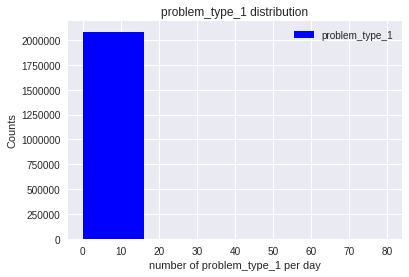

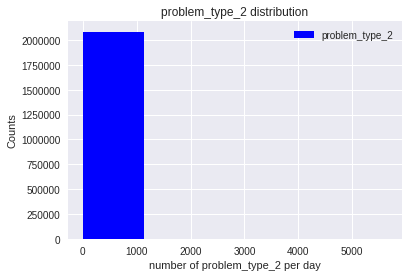

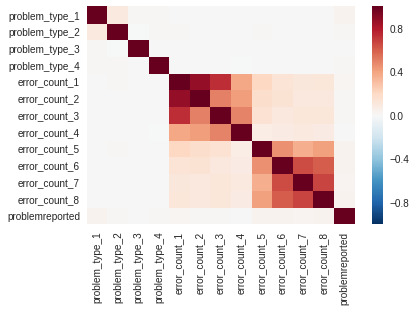

In [10]:
#------------------------------------ data exploration and visualization ------------------------------------#

# Register dataframe as a temp table in SQL context
df.createOrReplaceTempView("df1")

sqlStatement = """
    SELECT problem_type_1, problem_type_2, problem_type_3, problem_type_4,
    error_count_1, error_count_2, error_count_3, error_count_4, 
    error_count_5, error_count_6, error_count_7, error_count_8, problemreported
    FROM df1
"""
plotdata = spark.sql(sqlStatement).toPandas();


%matplotlib inline

# show histogram distribution of some features
ax1 = plotdata[['problem_type_1']].plot(kind='hist', bins=5, facecolor='blue')
ax1.set_title('problem_type_1 distribution')
ax1.set_xlabel('number of problem_type_1 per day'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

ax1 = plotdata[['problem_type_2']].plot(kind='hist', bins=5, facecolor='blue')
ax1.set_title('problem_type_2 distribution')
ax1.set_xlabel('number of problem_type_2 per day'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()


# show correlation matrix heatmap to explore some potential interesting patterns
corr = plotdata.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


## Feature Engineering

Developed comprehensive feature engineering pipeline to extract meaningful predictive signals from raw data.

### Temporal Feature Extraction

Created time-based features (month, week, day) and aggregated warning counts by type. Discovered and corrected negative values in warning counts through data quality validation.

In [11]:
# Extract some time features from "date" column
df = df.withColumn('month', month(df['date']))
df = df.withColumn('weekofyear', weekofyear(df['date']))
df = df.withColumn('dayofmonth', dayofmonth(df['date']))


# warning related raw features
warning_type1_features = list(s for s in df.columns if "warning_1_" in s) 
                            
warning_type2_features = list(s for s in df.columns if "warning_2_" in s)

warning_all = warning_type1_features + warning_type2_features

# total count of all type1 warnings each day each device
df = df.withColumn('warn_type1_total', sum(df[col_n] for col_n in warning_type1_features))
# total count of all type2 warnings each day each device
df = df.withColumn('warn_type2_total', sum(df[col_n] for col_n in warning_type2_features))

print(df['warn_type1_total',].head(3))
print(df['warn_type2_total',].head(3))


[Row(warn_type1_total=-430), Row(warn_type1_total=-430), Row(warn_type1_total=-419)]
[Row(warn_type2_total=-1040), Row(warn_type2_total=-1040), Row(warn_type2_total=-1040)]


In [12]:
# We realized that the warning counts have negative values
# Replace all the negative values with 0

def negative_replace(num):
    if num < 0: return 0
    else: return num
    
negative_replace_Udf = udf(negative_replace, IntegerType())

m = warning_type1_features + warning_type2_features
for col_n in m:
    df = df.withColumn(col_n, negative_replace_Udf(df[col_n]))

# Then we have to re-calculate the total warnings again 
df = df.withColumn('warn_type1_total', sum(df[col_n] for col_n in warning_type1_features))
df = df.withColumn('warn_type2_total', sum(df[col_n] for col_n in warning_type2_features))

print(df['warn_type1_total',].head(3))
print(df['warn_type2_total',].head(3))


[Row(warn_type1_total=0), Row(warn_type1_total=0), Row(warn_type1_total=1)]
[Row(warn_type2_total=0), Row(warn_type2_total=0), Row(warn_type2_total=0)]


### Categorical Feature Engineering

Implemented domain-driven binning strategy for categorical variables (categorical_1 to 4), creating interpretable groupings based on value distributions.

In [13]:
# Note: we can also use SparkSQL for this binning task

def Cat1(num):
    if num <= 10: return '0-10'
    elif 10 < num and num <= 20: return '11-20'
    elif 20 < num and num <= 30: return '21-30'
    elif 30 < num and num <= 40: return '31-40'
    else: return 'morethan40'
cat1Udf = udf(Cat1, StringType())
df = df.withColumn("cat1", cat1Udf('categorical_1'))


def Cat2(num):
    if num <= 2000: return '0-2000'
    elif 2000 < num and num <= 3000: return '2000-3000'
    elif 3000 < num and num <= 4000: return '3000-4000'
    elif 4000 < num and num <= 5000: return '4000-5000'
    elif 5000 < num and num <= 6000: return '5000-6000'
    else: return 'morethan6000'
cat2Udf = udf(Cat2, StringType())
df = df.withColumn("cat2", cat2Udf('categorical_2'))


def Cat3(num):
    if num <= 200: return '0-200'
    elif 200 < num and num <= 400: return '200-400'
    elif 400 < num and num <= 600: return '400-600'
    elif 600 < num and num <= 800: return '600-800'
    else: return 'morethan800'
cat3Udf = udf(Cat3, StringType())
df = df.withColumn("cat3", cat3Udf('categorical_3'))


def Cat4(num):
    if num <= 5000: return '0-5000'
    elif 5000 < num and num <= 10000: return '5000-10000'
    elif 10000 < num and num <= 15000: return '10000-15000'
    elif 15000 < num and num <= 20000: return '15000-20000'
    else: return 'morethan20000'
cat4Udf = udf(Cat4, StringType())
df = df.withColumn("cat4", cat4Udf('categorical_4'))


print(df.select('cat1').distinct().rdd.map(lambda r: r[0]).collect())
print(df.select('cat2').distinct().rdd.map(lambda r: r[0]).collect())
print(df.select('cat3').distinct().rdd.map(lambda r: r[0]).collect())
print(df.select('cat4').distinct().rdd.map(lambda r: r[0]).collect())


[u'11-20', u'21-30', u'0-10', u'31-40']
[u'2000-3000', u'morethan6000', u'5000-6000', u'3000-4000', u'0-2000', u'4000-5000']
[u'600-800', u'200-400', u'400-600', u'0-200']
[u'5000-10000', u'morethan20000', u'0-5000', u'15000-20000', u'10000-15000']


### Fault Code Feature Transformation

Converted fault code types from categorical to binary counts, enabling quantitative analysis of fault occurrences.

In [14]:
df = df.withColumn("fault_code_type_1_count",F.when(df.fault_code_type_1!= "Unknown", 1).otherwise(0))\
       .withColumn("fault_code_type_2_count",F.when(df.fault_code_type_2!= "Unknown", 1).otherwise(0))\
       .withColumn("fault_code_type_3_count",F.when(df.fault_code_type_3!= "Unknown", 1).otherwise(0))\
       .withColumn("fault_code_type_4_count",F.when(df.fault_code_type_4!= "Unknown", 1).otherwise(0))

df.groupby('fault_code_type_1_count').count().show()
df.groupby('fault_code_type_2_count').count().show()
df.groupby('fault_code_type_3_count').count().show()
df.groupby('fault_code_type_4_count').count().show()


+-----------------------+-------+
|fault_code_type_1_count|  count|
+-----------------------+-------+
|                      1|  50636|
|                      0|2034466|
+-----------------------+-------+

+-----------------------+-------+
|fault_code_type_2_count|  count|
+-----------------------+-------+
|                      1|  65676|
|                      0|2019426|
+-----------------------+-------+

+-----------------------+-------+
|fault_code_type_3_count|  count|
+-----------------------+-------+
|                      1|  86409|
|                      0|1998693|
+-----------------------+-------+

+-----------------------+-------+
|fault_code_type_4_count|  count|
+-----------------------+-------+
|                      1|  39593|
|                      0|2045509|
+-----------------------+-------+



### Performance Feature Normalization

**Key Insight:** Raw problem/error/fault counts could be misleading as they correlate with usage frequency.

**Solution:** Created normalized features by dividing problem counts by usage counts, providing usage-adjusted performance metrics that better represent true machine health.

In [15]:
# First, select the 8 raw performance features to be normalized
performance_normal_raw = ['problem_type_1','problem_type_2','problem_type_3','problem_type_4',
                          'fault_code_type_1_count','fault_code_type_2_count',
                          'fault_code_type_3_count', 'fault_code_type_4_count']

# Then, select 2 normalizers
performance_normalizer = ['usage_count_1','usage_count_2']

# Normalize performance_normal_raw by "usage_count_1"
df = df.withColumn("problem_type_1_per_usage1", F.when(df.usage_count_1==0,0).otherwise(df.problem_type_1/df.usage_count_1))\
       .withColumn("problem_type_2_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.problem_type_2/df.usage_count_1))\
       .withColumn("problem_type_3_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.problem_type_3/df.usage_count_1))\
       .withColumn("problem_type_4_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.problem_type_4/df.usage_count_1))\
       .withColumn("fault_code_type_1_count_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.fault_code_type_1_count/df.usage_count_1))\
       .withColumn("fault_code_type_2_count_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.fault_code_type_2_count/df.usage_count_1))\
       .withColumn("fault_code_type_3_count_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.fault_code_type_3_count/df.usage_count_1))\
       .withColumn("fault_code_type_4_count_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.fault_code_type_4_count/df.usage_count_1))

# Normalize performance_normal_raw by "usage_count_2"
df = df.withColumn("problem_type_1_per_usage2", F.when(df.usage_count_2==0,0).otherwise(df.problem_type_1/df.usage_count_2))\
       .withColumn("problem_type_2_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.problem_type_2/df.usage_count_2))\
       .withColumn("problem_type_3_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.problem_type_3/df.usage_count_2))\
       .withColumn("problem_type_4_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.problem_type_4/df.usage_count_2))\
       .withColumn("fault_code_type_1_count_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.fault_code_type_1_count/df.usage_count_2))\
       .withColumn("fault_code_type_2_count_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.fault_code_type_2_count/df.usage_count_2))\
       .withColumn("fault_code_type_3_count_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.fault_code_type_3_count/df.usage_count_2))\
       .withColumn("fault_code_type_4_count_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.fault_code_type_4_count/df.usage_count_2))


### Performance Feature Categorization

Applied adaptive binning strategies to performance metrics with custom bin sizes based on value distributions (e.g., '0', '1', '>1' for most features; '0', '1-5', '6-10', '>10' for problem_type_2).

In [16]:
# Define the list of performance related features which we would like to perform binning
c_names = ['problem_type_1', 'problem_type_3', 'problem_type_4',
           'problem_type_1_per_usage1','problem_type_2_per_usage1','problem_type_3_per_usage1','problem_type_4_per_usage1',
           'problem_type_1_per_usage2','problem_type_2_per_usage2','problem_type_3_per_usage2','problem_type_4_per_usage2',
           'fault_code_type_1_count', 'fault_code_type_2_count', 'fault_code_type_3_count', 'fault_code_type_4_count',                          
           'fault_code_type_1_count_per_usage1','fault_code_type_2_count_per_usage1',
           'fault_code_type_3_count_per_usage1', 'fault_code_type_4_count_per_usage1',
           'fault_code_type_1_count_per_usage2','fault_code_type_2_count_per_usage2',
           'fault_code_type_3_count_per_usage2', 'fault_code_type_4_count_per_usage2']

# Bin size ('0','1','>1') for most of the performance features because majority of the values fall into the range of 0 to slightly more than 1.
def performanceCat(num):
    if num == 0: return '0'
    elif num ==1: return '1'
    else: return '>1'
    
performanceCatUdf = udf(performanceCat, StringType())
for col_n in c_names:
    df = df.withColumn(col_n+'_category',performanceCatUdf(df[col_n]))

# Use different bin for "problem_type_2" because we saw a larger spread of the values
def problem_type_2_Cat(num):
    if num == 0: return '0'
    elif 0 < num and num <= 5: return '1-5'
    elif 5 < num and num <= 10: return '6-10'
    else: return '>10'

problem_type_2_CatUdf = udf(problem_type_2_Cat, StringType())
df = df.withColumn('problem_type_2_category',problem_type_2_CatUdf(df['problem_type_2']))


print(df.select('problem_type_1_category').distinct().rdd.map(lambda r: r[0]).collect())
print(df.select('problem_type_2_category').distinct().rdd.map(lambda r: r[0]).collect())


[u'0', u'>1', u'1']
[u'>10', u'0', u'6-10', u'1-5']


### One-Hot Encoding Pipeline

Implemented ML pipeline with StringIndexer and OneHotEncoder to transform categorical features, including variance-based feature filtering to remove uninformative single-level categories.

In [17]:
%%time

# Define the list of categorical features

catVarNames = ['problem_type_1_category', 'problem_type_2_category',
               'problem_type_3_category', 'problem_type_4_category',
               'problem_type_1_per_usage1_category', 'problem_type_2_per_usage1_category',
               'problem_type_3_per_usage1_category', 'problem_type_4_per_usage1_category',
               'problem_type_1_per_usage2_category', 'problem_type_2_per_usage2_category',
               'problem_type_3_per_usage2_category', 'problem_type_4_per_usage2_category',
               'fault_code_type_1_count_category', 'fault_code_type_2_count_category',
               'fault_code_type_3_count_category', 'fault_code_type_4_count_category',
               'fault_code_type_1_count_per_usage1_category', 'fault_code_type_2_count_per_usage1_category',
               'fault_code_type_3_count_per_usage1_category', 'fault_code_type_4_count_per_usage1_category',
               'fault_code_type_1_count_per_usage2_category', 'fault_code_type_2_count_per_usage2_category',
               'fault_code_type_3_count_per_usage2_category', 'fault_code_type_4_count_per_usage2_category',
               'cat1','cat2','cat3','cat4']
    
    
sIndexers = [StringIndexer(inputCol=x, outputCol=x + '_indexed') for x in catVarNames]

df_cat = Pipeline(stages=sIndexers).fit(df).transform(df)

# Remove columns with only 1 level (compute variances of columns)
catColVariance = df_cat.select(
    *(F.variance(df_cat[c]).alias(c + '_sd') for c in [cv + '_indexed' for cv in catVarNames]))
catColVariance = catColVariance.rdd.flatMap(lambda x: x).collect()
catVarNames = [catVarNames[k] for k in [i for i, v in enumerate(catColVariance) if v != 0]]

# Encode
ohEncoders = [OneHotEncoder(inputCol=x + '_indexed', outputCol=x + '_encoded')
              for x in catVarNames]
ohPipelineModel = Pipeline(stages=ohEncoders).fit(df_cat)
df_cat = ohPipelineModel.transform(df_cat)

drop_list = [col_n for col_n in df_cat.columns if 'indexed' in col_n]
df = df_cat.select([column for column in df_cat.columns if column not in drop_list])

print(df['problem_type_1_category_encoded',].head(3))


[Row(problem_type_1_category_encoded=SparseVector(2, {0: 1.0})), Row(problem_type_1_category_encoded=SparseVector(2, {0: 1.0})), Row(problem_type_1_category_encoded=SparseVector(2, {0: 1.0}))]
CPU times: user 747 ms, sys: 199 ms, total: 946 ms
Wall time: 13min 22s


### Dimensionality Reduction via PCA

**Challenge:** High-dimensional sparse warning features would make downstream rolling computations computationally prohibitive.

**Solution:** Applied Principal Component Analysis (PCA) to reduce warning features from multiple dimensions to 20 principal components, achieving significant dimensionality reduction while preserving variance. Validated component independence through correlation heatmap analysis.

In [18]:
## check the number of warning related features
len([col_n for col_n in df.columns if 'warning' in col_n])


147

In [19]:
%%time

#----------------------------- PCA feature grouping on warning related features --------------------------#

df = df.withColumn("key", concat(df.deviceid,lit("_"),df.date))

# step 1
# Use RFormula to create the feature vector
formula = RFormula(formula = "~" + "+".join(warning_all))
output = formula.fit(df).transform(df).select("key","features") 


# step 2
# Before PCA, we need to standardize the features, it is very important...
# Note that StandardScaler does not work for sparse vector unless withMean=false
# OR we can convert sparse vector to dense vector first using toArray
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(output)


# step 3
pca = PCA(k=20, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(scaledData)
result = model.transform(scaledData).select("key","pcaFeatures")

# to check how much variance explained by each component
print(model.explainedVariance)  


# step 4
# convert pca result, a vector column, to mulitple columns
# The reason why we did this was because later on we need to use those columns to generate more features (rolling compute) 
def extract(row):
    return (row.key, ) + tuple(float(x) for x in row.pcaFeatures.values)

pca_outcome = result.rdd.map(extract).toDF(["key"])

# rename columns of pca_outcome
oldColumns = pca_outcome.schema.names

newColumns = ["key", 
              "pca_1_warn","pca_2_warn","pca_3_warn","pca_4_warn","pca_5_warn",
              "pca_6_warn","pca_7_warn","pca_8_warn","pca_9_warn","pca_10_warn",
              "pca_11_warn","pca_12_warn","pca_13_warn","pca_14_warn","pca_15_warn",
              "pca_16_warn","pca_17_warn","pca_18_warn","pca_19_warn","pca_20_warn",
             ]

pca_result = reduce(lambda pca_outcome, idx: pca_outcome.withColumnRenamed(oldColumns[idx], newColumns[idx]), \
                                        xrange(len(oldColumns)), pca_outcome)

df = df.join(pca_result, 'key', 'inner')

print(df['pca_1_warn',].head(3))

warning_drop_list = [col_n for col_n in df.columns if 'warning_' in col_n]
df = df.select([column for column in df.columns if column not in warning_drop_list])


[0.0483107423499,0.0278314776592,0.0254509402103,0.0236091224214,0.0200247085239,0.0188475892993,0.0183962875162,0.0177510201652,0.0167993077022,0.0163456905185,0.016006950633,0.0155092512672,0.0144804538583,0.0140982528803,0.0139322569416,0.0137500740086,0.0136491126177,0.0129200916821,0.0122476113985,0.0115038758841]
[Row(pca_1_warn=0.0), Row(pca_1_warn=0.0), Row(pca_1_warn=0.0)]
CPU times: user 191 ms, sys: 39.2 ms, total: 230 ms
Wall time: 2min 43s


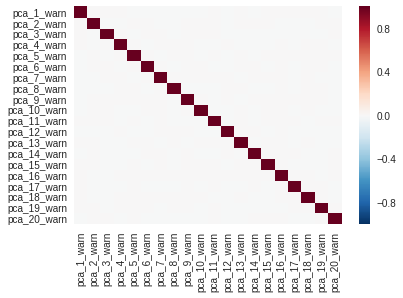

In [20]:
# I would like to visualize the relationship among the 20 pca components

# Register dataframe as a temp table in SQL context
df.createOrReplaceTempView("df2")

sqlStatement2 = """
    SELECT pca_1_warn, pca_2_warn, pca_3_warn, pca_4_warn, pca_5_warn, 
    pca_6_warn, pca_7_warn, pca_8_warn, pca_9_warn, pca_10_warn,
    pca_11_warn, pca_12_warn, pca_13_warn, pca_14_warn, pca_15_warn, 
    pca_16_warn, pca_17_warn, pca_18_warn, pca_19_warn, pca_20_warn
    FROM df2
"""
plotdata2 = spark.sql(sqlStatement2).toPandas();


%matplotlib inline
# show correlation matrix heatmap to explore some potential interesting patterns
corr = plotdata2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# From the plot we can see the 20 pca components do not overlap too much which is expected


## Save Result

Materialized intermediate results in Parquet format to optimize Spark's lazy evaluation and enable efficient data handoff to subsequent analysis stages (Notebook #2 for rolling feature computation).

In [21]:
%%time

df.write.mode('overwrite').parquet('/mnt/resource/PysparkExample/notebook1_result.parquet')


CPU times: user 87.6 ms, sys: 58.6 ms, total: 146 ms
Wall time: 2min 3s
